In [1]:
import pandas as pd
import os, re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import datetime
from tensorflow.keras import layers, models

2024-07-23 08:03:13.127805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 08:03:13.173516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 08:03:13.173552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 08:03:13.174542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 08:03:13.181346: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def load_images(path="coral_image_jpg"):
    train_folder = os.path.join(os.getcwd(), path, "train")
    test_folder = os.path.join(os.getcwd(), path, "test")
    
    X_train, X_test, Y_train, Y_test = [], [], [], []
    
    # Loading images from train folder to X_train and label to Y_train
    train_count = 0
    for image_fname in os.listdir(train_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.jpg', image_fname)
        if not image_re:
            print(f"Filename {image_fname} does not match the expected pattern.")
            continue
        
        image_path = os.path.join(train_folder, image_fname)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        
        try:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except cv2.error as e:
            print(f"Error converting image: {image_path}. Error: {e}")
            continue
        
        label = int(image_re.group(2))  # Convert label to integer
        
        X_train.append(image_rgb)
        Y_train.append(label)
        train_count += 1
        if train_count % 1000 == 0:
            print(f"Loaded {train_count} training images.")
    print("Loaded train folder")
    
    # Loading images from test folder to X_test and label to Y_test
    test_count = 0
    for image_fname in os.listdir(test_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.jpg', image_fname)
        if not image_re:
            print(f"Filename {image_fname} does not match the expected pattern.")
            continue
        
        image_path = os.path.join(test_folder, image_fname)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        
        try:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except cv2.error as e:
            print(f"Error converting image: {image_path}. Error: {e}")
            continue
        
        label = int(image_re.group(2))  # Convert label to integer
        
        X_test.append(image_rgb)
        Y_test.append(label)
        test_count += 1
        if test_count % 1000 == 0:
            print(f"Loaded {test_count} testing images.")
    print("Loaded test folder")
    
    return X_train, X_test, Y_train, Y_test

# Call the function to load images
X_train, X_test, Y_train, Y_test = load_images()

Loaded 1000 training images.
Filename .ipynb_checkpoints does not match the expected pattern.
Loaded 2000 training images.
Loaded 3000 training images.
Loaded 4000 training images.
Loaded train folder
Filename .ipynb_checkpoints does not match the expected pattern.
Loaded test folder


In [3]:
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(Y_train)
y_test = np.array(Y_test)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4112, 225, 225, 3)
(258, 225, 225, 3)
(4112,)
(258,)


In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /=255

In [5]:
from keras.utils import to_categorical

print("Shape before one-hot encoding : ",y_train.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("Shape after one-hot encoding : ",y_test.shape)

Shape before one-hot encoding :  (4112,)
Shape after one-hot encoding :  (258, 2)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [7]:
def create_VGG_model(input_shape=(225, 225, 3), num_classes=2):
    # Create a sequential model
    model = Sequential()
    # Load the pretrained VGG19 model without the top layers
    pretrained_model = VGG19(
        include_top=False,
        weights='imagenet',
        input_tensor=Input(shape=input_shape),
        pooling='max'
    )
    # Freeze the layers of the pretrained model
    pretrained_model.trainable = False
    # Add the pretrained model to the sequential model
    model.add(pretrained_model)
    # Add new layers on top of the pretrained model
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.45))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.45))
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = create_VGG_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       

In [10]:
# Create checkpoint callback
checkpoint_path = "corals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10)

In [8]:
model.compile(optimizer=Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
history = model.fit(
    x_train, y_train ,epochs=20,validation_data=(x_test, y_test), batch_size=32,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "corals_classification"),
        checkpoint_callback,
        reduce_lr
    ])

Saving TensorBoard log files to: training_logs/corals_classification/20240713-030329
Epoch 1/20
129/129 [==============================] - 587s 5s/step - loss: 0.8259 - accuracy: 0.6469 - val_loss: 0.7062 - val_accuracy: 0.6163 - lr: 0.0010
Epoch 2/20
129/129 [==============================] - 584s 5s/step - loss: 0.5880 - accuracy: 0.7364 - val_loss: 0.5011 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 3/20
129/129 [==============================] - 583s 5s/step - loss: 0.5095 - accuracy: 0.7639 - val_loss: 0.6999 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 4/20
129/129 [==============================] - 583s 5s/step - loss: 0.4694 - accuracy: 0.7865 - val_loss: 0.5046 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 5/20
129/129 [==============================] - 582s 5s/step - loss: 0.4435 - accuracy: 0.8037 - val_loss: 0.5021 - val_accuracy: 0.7636 - lr: 0.0010
Epoch 6/20
129/129 [==============================] - 582s 5s/step - loss: 0.4282 - accuracy: 0.8062 - val_loss: 0.4827 - val_accuracy:

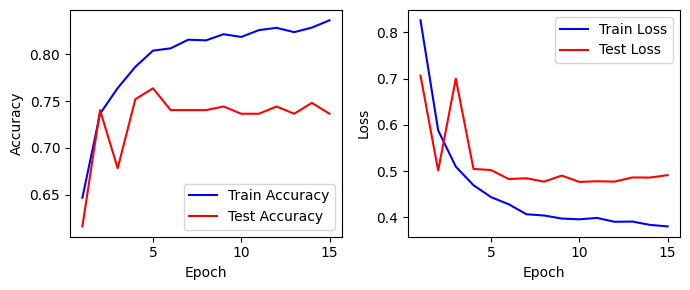

In [12]:
acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1,len(acc2)+1)
 
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
 
axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
 
axes[1].plot(epochs, loss2,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
 
# Adjusting layout for better spacing
plt.tight_layout()
 
# Display the figure
plt.show()

In [13]:
loss, accuracy = model.evaluate(x_test,y_test)
print(f'Test Accuracy {accuracy*100:.2f}%')

9/9 [==============================] - 34s 4s/step - loss: 0.4765 - accuracy: 0.7364
Test Accuracy 73.64%


In [14]:
import numpy as np
from sklearn.metrics import classification_report

predict_x = model.predict(x_test)
predict1 = np.argmax(predict_x, axis = 1)
print(predict1)

target_names = ["Class {}".format(i) for i in range(2)]
print(classification_report(np.array([int(class_) for class_ in Y_test]), predict1, target_names = target_names))

9/9 [==============================] - 35s 4s/step
[1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1
 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0
 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0
 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1
 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1]
              precision    recall  f1-score   support

     Class 0       0.76      0.74      0.75       137
     Class 1       0.71      0.74      0.72       121

    accuracy                           0.74       258
   macro avg       0.74      0.74      0.74       258
weighted avg       0.74      0.74      0.74       258



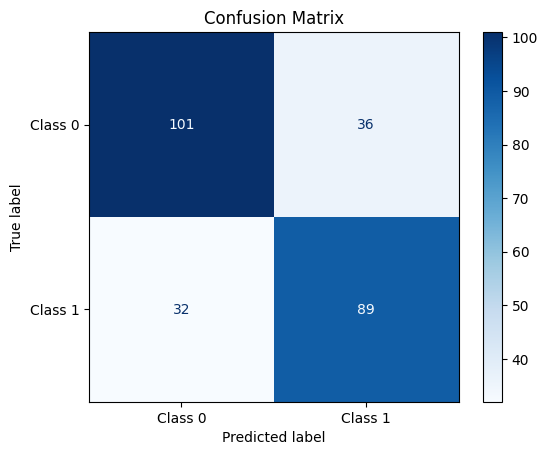

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Compute confusion matrix
cm = confusion_matrix(np.array([int(class_) for class_ in Y_test]), predict1)

#Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [18]:
model.save('VGG19_Final_Model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import pickle

# Save the history object
with open('history_VGG19_Final.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [4]:
def create_VGG_model(input_shape=(225, 225, 3), num_classes=2):
    # Create a sequential model
    model = Sequential()
    # Load the pretrained VGG19 model without the top layers
    pretrained_model = VGG19(
        include_top=False,
        weights='imagenet',
        input_tensor=Input(shape=input_shape),
        pooling='max'
    )
    # Freeze the layers of the pretrained model
    pretrained_model.trainable = False
    # Add the pretrained model to the sequential model
    model.add(pretrained_model)
    # Add new layers on top of the pretrained model
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.45))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.45))
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = create_VGG_model()
model.summary()

# Assuming this function is defined in your code
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

# Find the last convolutional layer of the pre-trained VGG19 part
last_conv_layer_name = find_last_conv_layer(model.layers[0])

# Dictionary to map model names to their last conv layer names
last_conv_layer_names = {
    'Model CNN': 'conv2d',  # Replace with actual last conv layer name
    'Model EffNet': "dense_2",  # Replace with actual last conv layer name
    'Model ResNet': 'conv2d',  # Replace with actual last conv layer name
    'Model VGG19': last_conv_layer_name,  # Use the correct last conv layer name
}

print("Last conv layer name for VGG19:", last_conv_layer_name)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                     